In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aipy as a 
from scipy.sparse import csr_matrix
from tqdm import tqdm
import hera_cal.omni as omni
from copy import deepcopy
import linsolve
#import seaborn
%matplotlib notebook 

# Array Code

In [2]:
class InterferometricArray():
    """Class that takes a list of positions and can calcuate baselines and redundancies."""
    
    def __init__(self, positions=[]):
        self.positions = np.array(positions)
        self.nant = len(positions)
        self.antNames = range(self.nant)
    
    def CalculateUBLs(self, precisionFactor=1000000):
        """Finds the baselines, unique baselines, and related dictionaries for indexing."""
        self.blVectors, self.blNamePairs, self.blIndexPairs = [], [], []
        self.index2name = {i:name for i,name in enumerate(self.antNames)}
        self.name2index = {name:i for i,name in enumerate(self.antNames)}
        self.name2pos = {name: self.positions[self.name2index[name]] for name in self.antNames}
        for index1,ant1 in enumerate(self.antNames):
            for index2,ant2 in zip(range(index1+1,self.nant), self.antNames[index1+1:]):
                delta = np.array([int(np.round(precisionFactor*(self.positions[index1][i] - self.positions[index2][i]))) for i in range(3)])
                if delta[1] > 0 or (delta[1] == 0 and delta[0] > 0): 
                    self.blVectors.append(tuple(delta))
                    self.blNamePairs.append((ant1, ant2))
                    self.blIndexPairs.append((index1, index2))
                else: 
                    self.blVectors.append(tuple(-delta))
                    self.blNamePairs.append((ant2, ant1))
                    self.blIndexPairs.append((index2, index1))
        self.ublDict = {}
        for b in range(len(self.blVectors)):
            if self.ublDict.has_key(self.blVectors[b]): self.ublDict[self.blVectors[b]].append(self.blNamePairs[b])
            else: self.ublDict[self.blVectors[b]] = [self.blNamePairs[b]]
        self.blIndexDict = {antPair: i for i,antPair in enumerate(self.blNamePairs)}
        self.names2ublIndex = {antPair: i for i,antPairs in enumerate(self.ublDict.values()) for antPair in antPairs}
        self.indices2ublIndex = {(self.name2index[antPair[0]],self.name2index[antPair[1]]): 
                                 i for i,antPairs in enumerate(self.ublDict.values()) for antPair in antPairs}
        self.ublVectors = np.array([self.name2pos[antList[0][0]]-self.name2pos[antList[0][1]] for antList in self.ublDict.values()])
        self.ublGroups = [antList for antList in self.ublDict.values()]
        print "With", len(self.positions), "antennas there are", len(self.ublDict.items()), "unique baselines."
        self.nbl, self.nubl = len(self.blNamePairs), len(self.ublVectors)

class HexagonalArray(InterferometricArray):
    """Generates a hexagonal array."""
    
    def __init__(self, separation, hexNum, verbose=False):
        """Creates a hexagonal array with hexNum antennas per side separated by separation."""
        self.hexNum, self.separation, self.verbose = hexNum, separation, verbose
        positions, self.rowIndices, i = [], [], 0        
        for row in range(hexNum-1,-(hexNum),-1):
            indices = []
            for col in range(2*hexNum-abs(row)-1):
                xPos = ((-(2*hexNum-abs(row))+2)/2.0 + col)*separation;
                yPos = row*separation*3**.5/2;
                positions.append([xPos, yPos, 0])
                indices.append(i); i+=1
            self.rowIndices.append(indices)
        self.positions = np.array(positions) 
        self.nant = len(self.positions)
        self.antNames = range(self.nant)

# Omnical with a single polarization

In [3]:
ha = HexagonalArray(14.7, 3)
pos = [[0,0,0],[0,1,0],[0,2,0],[0,3,0],[1,0,0],[1,1,0],[1,2,0],[1,3,0]]
ha = InterferometricArray(positions=pos)
ha.CalculateUBLs()

trueVis = {}
for group in ha.ublGroups: 
    trueVis[group[0]] = np.random.randn() + 1.0j*np.random.randn()

trueGains = {}
for ant in ha.antNames:
    trueGains[ant] = 1.0 + .1*(np.random.randn() + np.random.randn())

obsVis, equations = {}, {}
for group in ha.ublGroups: 
    for (i,j) in group:
        obsVis[(i,j)] = trueGains[i] * np.conj(trueGains[j]) * trueVis[group[0]]# + .01*np.random.randn() + .01j*np.random.randn()
        equations['g{} * g{}_ * v{}to{}'.format(i,j,group[0][0], group[0][1])] = obsVis[(i,j)]

logSolver = linsolve.LogProductSolver(equations)
logSol = logSolver.solve()
linSolver = linsolve.LinProductSolver(equations, logSol)
linSol = linSolver.solve()

chiSq = 0
for group in ha.ublGroups: 
    for (i,j) in group:
        chiSq += np.abs(obsVis[(i,j)] - linSol['g{}'.format(i)] * np.conj(linSol['g{}'.format(j)]) 
                        * linSol['v{}to{}'.format(group[0][0], group[0][1])])**2
print 'Chisq:', chiSq



A = linSolver.ls.get_A()
A = A.reshape((A.shape[0],A.shape[1]))
AtA = A.T.dot(A)
print 'Number of omnical degeneracies: ', len(AtA) - np.linalg.matrix_rank(AtA)



With 8 antennas there are 10 unique baselines.
Chisq: 1.26437300849e-30
Number of omnical degeneracies:  4


In [4]:
ha = HexagonalArray(14.7, 3)
pos = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0],[1,0,0],[1,1,0],[1,2,0],[1,3,0]])
ha = InterferometricArray(positions=pos)
ha.CalculateUBLs()
antpols = ['x']
vispols = ['xx']

trueVis = {}
for group in ha.ublGroups: 
    trueVis[group[0]] = {pol: np.random.randn() + 1.0j*np.random.randn() for pol in vispols}

trueGains = {}
for ant in ha.antNames:
    trueGains[ant] = {pol: 1.0 + .1*(np.random.randn() + np.random.randn()) for pol in antpols}

obsVis, equations = {}, {}
for group in ha.ublGroups: 
    for (i,j) in group:
        obsVis[(i,j)] = {pol: trueGains[i][pol[0]] * np.conj(trueGains[j][pol[1]]) * trueVis[group[0]][pol] for pol in vispols}
        for pol in vispols:
            eqStr = 'g{}{} * g{}{}_ * v{}to{}{}'.format(i,pol[0],j,pol[1],group[0][0],group[0][1],pol)
            equations[eqStr] = obsVis[(i,j)][pol]

logSolver = linsolve.LogProductSolver(equations)
logSol = logSolver.solve()
linSolver = linsolve.LinProductSolver(equations, logSol)
linSol = linSolver.solve()

chiSq = 0
for group in ha.ublGroups: 
    for (i,j) in group:
        for pol in vispols:
            if pol == 'yx':
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * np.conj(linSol['v{}to{}xy'.format(group[0][0], group[0][1])]))**2
            else:
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * linSol['v{}to{}{}'.format(group[0][0], group[0][1], pol)])**2
                
                
print 'Chisq:', chiSq


phix = 1.0
phiy = .5
Ax = 2.0
Ay = 3.0
Phi = np.array([-1.0,1.5,0])

print pos.shape

for key,sol in linSol.items():
#     print key
#     print int(key[4]), int(key[1])
#     print pos[int(key[4]),:] - pos[int(key[1]),:]
    if key[0] == 'g':
        if key[2] == 'x':
            linSol[key] *= Ax * np.exp(1.0j*phix) * np.exp(1.0j * Phi.dot(pos[int(key[1]),:]))
        if key[2] == 'y':
            linSol[key] *= Ay * np.exp(1.0j*phiy) * np.exp(1.0j * Phi.dot(pos[int(key[1]),:]))
    if key[0] == 'v':
        if key[-2:] == 'xy':
            linSol[key] *= np.exp(1.0j*(phiy-phix)) / Ax / Ay * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'yx':
            linSol[key] *= np.exp(1.0j*(phix-phiy)) / Ax / Ay * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'xx':
            linSol[key] *= Ax**-2 * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'yy':
            linSol[key] *= Ay**-2 * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
    
chiSq = 0
for group in ha.ublGroups: 
    for (i,j) in group:
        for pol in vispols:
            if pol == 'yx':
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * np.conj(linSol['v{}to{}xy'.format(group[0][0], group[0][1])]))**2
            else:
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * linSol['v{}to{}{}'.format(group[0][0], group[0][1], pol)])**2
                
                
print 'Chisq:', chiSq

A = linSolver.ls.get_A()
A = A.reshape((A.shape[0],A.shape[1]))
AtA = A.T.dot(A)
print 'Number of omnical degeneracies: ', len(AtA) - np.linalg.matrix_rank(AtA)

With 8 antennas there are 10 unique baselines.
Chisq: 5.70018087493e-31
(8, 3)
Chisq: 1.0718191345e-30
Number of omnical degeneracies:  4


# Omnical with two independent polarizations ($xx$ and $yy$ only)

In [5]:
ha = HexagonalArray(14.7, 3)
pos = [[0,0,0],[0,1,0],[0,2,0],[0,3,0],[1,0,0],[1,1,0],[1,2,0],[1,3,0]]
ha = InterferometricArray(positions=pos)
ha.CalculateUBLs()
antpols = ['x','y']
vispols = ['xx','yy']

trueVis = {}
for group in ha.ublGroups: 
    trueVis[group[0]] = {pol: np.random.randn() + 1.0j*np.random.randn() for pol in vispols}

trueGains = {}
for ant in ha.antNames:
    trueGains[ant] = {pol: 1.0 + .1*(np.random.randn() + np.random.randn()) for pol in antpols}

obsVis, equations = {}, {}
for group in ha.ublGroups: 
    for (i,j) in group:
        obsVis[(i,j)] = {pol: trueGains[i][pol[0]] * np.conj(trueGains[j][pol[1]]) * trueVis[group[0]][pol] for pol in vispols}
        for pol in vispols:
            eqStr = 'g{}{} * g{}{}_ * v{}to{}{}'.format(i,pol[0],j,pol[1],group[0][0],group[0][1],pol)
            equations[eqStr] = obsVis[(i,j)][pol]

logSolver = linsolve.LogProductSolver(equations)
logSol = logSolver.solve()
linSolver = linsolve.LinProductSolver(equations, logSol)
linSol = linSolver.solve()

chiSq = 0
for group in ha.ublGroups: 
    for (i,j) in group:
        for pol in vispols:
            chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                            * linSol['v{}to{}{}'.format(group[0][0], group[0][1], pol)])**2
print 'Chisq:', chiSq

A = linSolver.ls.get_A()
A = A.reshape((A.shape[0],A.shape[1]))
AtA = A.T.dot(A)
print 'Number of omnical degeneracies: ', len(AtA) - np.linalg.matrix_rank(AtA)

With 8 antennas there are 10 unique baselines.
Chisq: 2.85607285736e-30
Number of omnical degeneracies:  8


# Omnical with four independent visibility polarizations ($V_{xy} \neq V^*_{yx}$)

In [6]:
ha = HexagonalArray(14.7, 3)
pos = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0],[1,0,0],[1,1,0],[1,2,0],[1,3,0]])
ha = InterferometricArray(positions=pos)

ha.CalculateUBLs()
antpols = ['x','y']
vispols = ['xx','yy','xy','yx']

trueVis = {}
for group in ha.ublGroups: 
    trueVis[group[0]] = {pol: np.random.randn() + 1.0j*np.random.randn() for pol in vispols}

trueGains = {}
for ant in ha.antNames:
    trueGains[ant] = {pol: 1.0 + .01*(np.random.randn() + np.random.randn()) for pol in antpols}

obsVis, equations = {}, {}
for group in ha.ublGroups: 
    for (i,j) in group:
        obsVis[(i,j)] = {pol: trueGains[i][pol[0]] * np.conj(trueGains[j][pol[1]]) * trueVis[group[0]][pol] for pol in vispols}
        for pol in vispols:
            eqStr = 'g{}{} * g{}{}_ * v{}to{}{}'.format(i,pol[0],j,pol[1],group[0][0],group[0][1],pol)
            equations[eqStr] = obsVis[(i,j)][pol]

            

            
logSolver = linsolve.LogProductSolver(equations)
logSol = logSolver.solve()
linSolver = linsolve.LinProductSolver(equations, logSol)
linSol = linSolver.solve()

chiSq = 0
for group in ha.ublGroups: 
    for (i,j) in group:
        for pol in vispols:
            chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                            * linSol['v{}to{}{}'.format(group[0][0], group[0][1], pol)])**2
print 'Chisq:', chiSq

phix = 1.0
phiy = .5
Ax = 2.0
Ay = 3.0
Phi = np.array([-1.0,1.5,0])


#print linSol.keys()
for key,sol in linSol.items():
    if key[0] == 'g':
        if key[2] == 'x':
            linSol[key] *= Ax * np.exp(1.0j*phix) * np.exp(1.0j * Phi.dot(pos[int(key[1]),:]))
        if key[2] == 'y':
            linSol[key] *= Ay * np.exp(1.0j*phiy) * np.exp(1.0j * Phi.dot(pos[int(key[1]),:]))
    if key[0] == 'v':
        if key[-2:] == 'xy':
            linSol[key] *= np.exp(1.0j*(phiy-phix)) / Ax / Ay * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'yx':
            linSol[key] *= np.exp(1.0j*(phix-phiy)) / Ax / Ay * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'xx':
            linSol[key] *= Ax**-2 * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'yy':
            linSol[key] *= Ay**-2 * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))

chiSq = 0
for group in ha.ublGroups: 
    for (i,j) in group:
        for pol in vispols:
            chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                            * linSol['v{}to{}{}'.format(group[0][0], group[0][1], pol)])**2
print 'Chisq:', chiSq            
            
A = linSolver.ls.get_A()
A = A.reshape((A.shape[0],A.shape[1]))
AtA = A.T.dot(A)
print 'Number of omnical degeneracies: ', len(AtA) - np.linalg.matrix_rank(AtA)

# print linSolver.ls.dtype
print linSolver.ls.re_im_split
# print A.shape
# print len(ha.ublGroups)
# print 

With 8 antennas there are 10 unique baselines.
Chisq: 3.95117768859e-30
Chisq: 8.89999912544e-30
Number of omnical degeneracies:  6
True


# Omnical with four independent visibility polarizations ($V_{xy} \equiv V^*_{yx}$)

In [7]:
ha = HexagonalArray(14.7, 3)
pos = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0],[1,0,0],[1,1,0],[1,2,0],[1,3,0]])
ha = InterferometricArray(positions=pos)

ha.CalculateUBLs()
antpols = ['x','y']
vispols = ['xx','yy','xy','yx']

trueVis = {}
for group in ha.ublGroups: 
    trueVis[group[0]] = {pol: np.random.randn() + 1.0j*np.random.randn() for pol in vispols}
    trueVis[group[0]]['yx'] = np.conj(trueVis[group[0]]['xy'])

trueGains = {}
for ant in ha.antNames:
    trueGains[ant] = {pol: 1.0 + .01*(np.random.randn() + np.random.randn()) for pol in antpols}

obsVis, equations = {}, {}
for group in ha.ublGroups: 
    for (i,j) in group:
        obsVis[(i,j)] = {pol: trueGains[i][pol[0]] * np.conj(trueGains[j][pol[1]]) * trueVis[group[0]][pol] for pol in vispols}
        for pol in vispols:
            if pol == 'yx':
                eqStr = 'g{}{} * g{}{}_ * v{}to{}xy_'.format(i,pol[0],j,pol[1],group[0][0],group[0][1])
            else:
                eqStr = 'g{}{} * g{}{}_ * v{}to{}{}'.format(i,pol[0],j,pol[1],group[0][0],group[0][1],pol)
            equations[eqStr] = obsVis[(i,j)][pol]

logSolver = linsolve.LogProductSolver(equations)
logSol = logSolver.solve()
linSolver = linsolve.LinProductSolver(equations, logSol)
linSol = linSolver.solve()

chiSq = 0
for group in ha.ublGroups: 
    for (i,j) in group:
        for pol in vispols:
            if pol == 'yx':
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * np.conj(linSol['v{}to{}xy'.format(group[0][0], group[0][1])]))**2
            else:
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * linSol['v{}to{}{}'.format(group[0][0], group[0][1], pol)])**2
                
                
print 'Chisq:', chiSq


phix = 1.0
phiy = .5
Ax = 2.0
Ay = 3.0
Phi = np.array([-1.0,1.5,0])


#print linSol.keys()
for key,sol in linSol.items():
    if key[0] == 'g':
        if key[2] == 'x':
            linSol[key] *= Ax * np.exp(1.0j*phix) * np.exp(1.0j * Phi.dot(pos[int(key[1]),:]))
        if key[2] == 'y':
            linSol[key] *= Ay * np.exp(1.0j*phiy) * np.exp(1.0j * Phi.dot(pos[int(key[1]),:]))
    if key[0] == 'v':
        if key[-2:] == 'xy':
            linSol[key] *= np.exp(1.0j*(phiy-phix)) / Ax / Ay * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'yx':
            linSol[key] *= np.exp(1.0j*(phix-phiy)) / Ax / Ay * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'xx':
            linSol[key] *= Ax**-2 * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'yy':
            linSol[key] *= Ay**-2 * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
    
chiSq = 0
for group in ha.ublGroups: 
    for (i,j) in group:
        for pol in vispols:
            if pol == 'yx':
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * np.conj(linSol['v{}to{}xy'.format(group[0][0], group[0][1])]))**2
            else:
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * linSol['v{}to{}{}'.format(group[0][0], group[0][1], pol)])**2
                
                
print 'Chisq:', chiSq

A = linSolver.ls.get_A()
A = A.reshape((A.shape[0],A.shape[1]))
AtA = A.T.dot(A)
print 'Number of omnical degeneracies: ', len(AtA) - np.linalg.matrix_rank(AtA)



With 8 antennas there are 10 unique baselines.
Chisq: 3.43068308406e-30
Chisq: 88.6643925721
Number of omnical degeneracies:  4


<IPython.core.display.Javascript object>


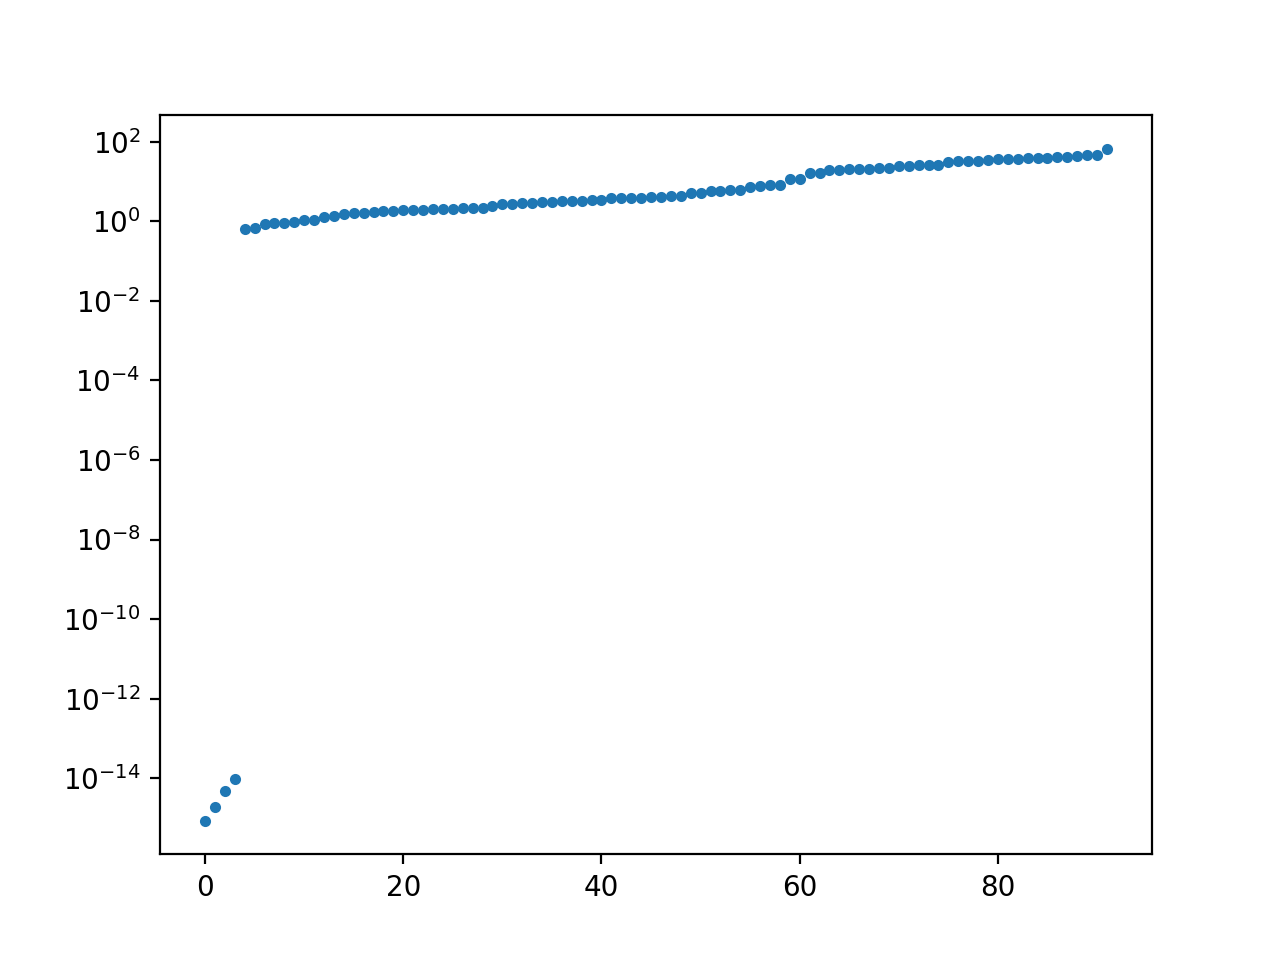

In [8]:
plt.figure()
plt.semilogy(sorted(np.abs(np.linalg.eig(AtA)[0])),'.')

# $V_{ij}^{xy} = V_{ji}^{yx}$

In [15]:
ha = HexagonalArray(14.7, 3)
pos = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0],[1,0,0],[1,1,0],[1,2,0],[1,3,0]])
ha = InterferometricArray(positions=pos)

ha.CalculateUBLs()
antpols = ['x','y']
vispols = ['xx','yy','xy','yx']

trueVis = {}
for group in ha.ublGroups: 
    trueVis[group[0]] = {pol: np.random.randn() + 1.0j*np.random.randn() for pol in vispols}
    trueVis[group[0]]['yx'] = trueVis[group[0]]['xy']

trueGains = {}
for ant in ha.antNames:
    trueGains[ant] = {pol: 1.0 + .01*(np.random.randn() + np.random.randn()) for pol in antpols}

obsVis, equations = {}, {}
for group in ha.ublGroups: 
    for (i,j) in group:
        obsVis[(i,j)] = {pol: trueGains[i][pol[0]] * np.conj(trueGains[j][pol[1]]) * trueVis[group[0]][pol] for pol in vispols}
        for pol in vispols:
            if pol == 'yx':
                eqStr = 'g{}{} * g{}{}_ * v{}to{}xy'.format(i,pol[0],j,pol[1],group[0][0],group[0][1])
            else:
                eqStr = 'g{}{} * g{}{}_ * v{}to{}{}'.format(i,pol[0],j,pol[1],group[0][0],group[0][1],pol)
            equations[eqStr] = obsVis[(i,j)][pol]

logSolver = linsolve.LogProductSolver(equations)
logSol = logSolver.solve()
linSolver = linsolve.LinProductSolver(equations, logSol)
linSol = linSolver.solve()

chiSq = 0
for group in ha.ublGroups: 
    for (i,j) in group:
        for pol in vispols:
            if pol == 'yx':
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * linSol['v{}to{}xy'.format(group[0][0], group[0][1])])**2
            else:
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * linSol['v{}to{}{}'.format(group[0][0], group[0][1], pol)])**2
                
                
print 'Chisq:', chiSq


phix = 1.0
phiy = 1.0#.5
Ax = 2.0
Ay = 3.0
Phi = 1*np.array([-1.0,1.5,0])


#print linSol.keys()
for key,sol in linSol.items():
    if key[0] == 'g':
        if key[2] == 'x':
            linSol[key] *= Ax * np.exp(1.0j*phix) * np.exp(1.0j * Phi.dot(pos[int(key[1]),:]))
        if key[2] == 'y':
            linSol[key] *= Ay * np.exp(1.0j*phiy) * np.exp(1.0j * Phi.dot(pos[int(key[1]),:]))
    if key[0] == 'v':
        if key[-2:] == 'xy':
            linSol[key] *= np.exp(1.0j*(phiy-phix)) / Ax / Ay * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'yx':
            linSol[key] *= np.exp(1.0j*(phix-phiy)) / Ax / Ay * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'xx':
            linSol[key] *= Ax**-2 * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
        elif key[-2:] == 'yy':
            linSol[key] *= Ay**-2 * np.exp(1.0j * Phi.dot(pos[int(key[4]),:]-pos[int(key[1]),:]))
    
chiSq = 0
for group in ha.ublGroups: 
    for (i,j) in group:
        for pol in vispols:
            if pol == 'yx':
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * linSol['v{}to{}xy'.format(group[0][0], group[0][1])])**2
            else:
                chiSq += np.abs(obsVis[(i,j)][pol] - linSol['g{}{}'.format(i,pol[0])] * np.conj(linSol['g{}{}'.format(j,pol[1])])
                                * linSol['v{}to{}{}'.format(group[0][0], group[0][1], pol)])**2
                
                
print 'Chisq:', chiSq

A = linSolver.ls.get_A()
A = A.reshape((A.shape[0],A.shape[1]))
AtA = A.T.dot(A)
print 'Number of omnical degeneracies: ', len(AtA) - np.linalg.matrix_rank(AtA)



With 8 antennas there are 10 unique baselines.
Chisq: 4.71206521369e-30
Chisq: 1.54859520453e-29
Number of omnical degeneracies:  5
